In [73]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sn

# Hypothyroid Disease Classification
### Group 17: Matthew Gillies, Ryan Lee, Eric Liu

## EDA and Data Tidying

In [74]:
## Reading in data
hypothyroid_df = pd.read_csv("data/hypothyroid.csv")
hypothyroid_df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [75]:
hypothyroid_df.shape

(3772, 30)

In [76]:
## Replacing ? values with NA
hypothyroid = hypothyroid_df.replace("?", np.nan)

In [77]:
hypothyroid.isna().sum()

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
binaryClass   

In [78]:
## **** Not sure if we want to drop NA's or impute?
## Due to large amount of NA values in TBG and T3 these features will be removed from the dataset. 
## All "measured" features will also be removed as once NA's are removed they will all be "t"
## We will also removed the referral source column as it is quite irrelevant
## All other NA rows will simply be dropped
hypo = hypothyroid.drop(columns = ["TBG", "TBG measured", "T3", "T3 measured", "TSH measured", "TT4 measured", "FTI measured"
                                   , "T4U measured", "referral source"])

In [79]:
hypo_clean = hypo.dropna()

In [80]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 3771
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3103 non-null   object
 1   sex                        3103 non-null   object
 2   on thyroxine               3103 non-null   object
 3   query on thyroxine         3103 non-null   object
 4   on antithyroid medication  3103 non-null   object
 5   sick                       3103 non-null   object
 6   pregnant                   3103 non-null   object
 7   thyroid surgery            3103 non-null   object
 8   I131 treatment             3103 non-null   object
 9   query hypothyroid          3103 non-null   object
 10  query hyperthyroid         3103 non-null   object
 11  lithium                    3103 non-null   object
 12  goitre                     3103 non-null   object
 13  tumor                      3103 non-null   object
 14  hypopitu

In [81]:
## Changing Dtype of the columns to numeric/categorical 
num_cols = ['age', 'TSH', 'TT4', 'T4U', 'FTI']
cat_cols = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych', 'binaryClass',
           'hypopituitary']
hypo_clean[num_cols] = hypo_clean[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
for col in cat_cols:
    hypo_clean[col] = hypo_clean[col].astype('category')

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_24127/414099628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypo_clean[num_cols] = hypo_clean[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_24127/414099628.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypo_clean[col] = hypo_clean[col].astype('category')
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_24127/414099628.py:8: SettingWithCopyWarning: 
A value i

In [98]:
## Changing binaryClass so 0 represents negative and 1 represents positive
hypo_clean['binaryClass'] = hypo_clean['binaryClass'].replace(["N", "P"], [0,1])

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_24127/3976262766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypo_clean['binaryClass'] = hypo_clean['binaryClass'].replace(["N", "P"], [0,1])


In [99]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 3771
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3103 non-null   float64 
 1   sex                        3103 non-null   category
 2   on thyroxine               3103 non-null   category
 3   query on thyroxine         3103 non-null   category
 4   on antithyroid medication  3103 non-null   category
 5   sick                       3103 non-null   category
 6   pregnant                   3103 non-null   category
 7   thyroid surgery            3103 non-null   category
 8   I131 treatment             3103 non-null   category
 9   query hypothyroid          3103 non-null   category
 10  query hyperthyroid         3103 non-null   category
 11  lithium                    3103 non-null   category
 12  goitre                     3103 non-null   category
 13  tumor                      3103 n

Figure 1: Correlations of numeric features


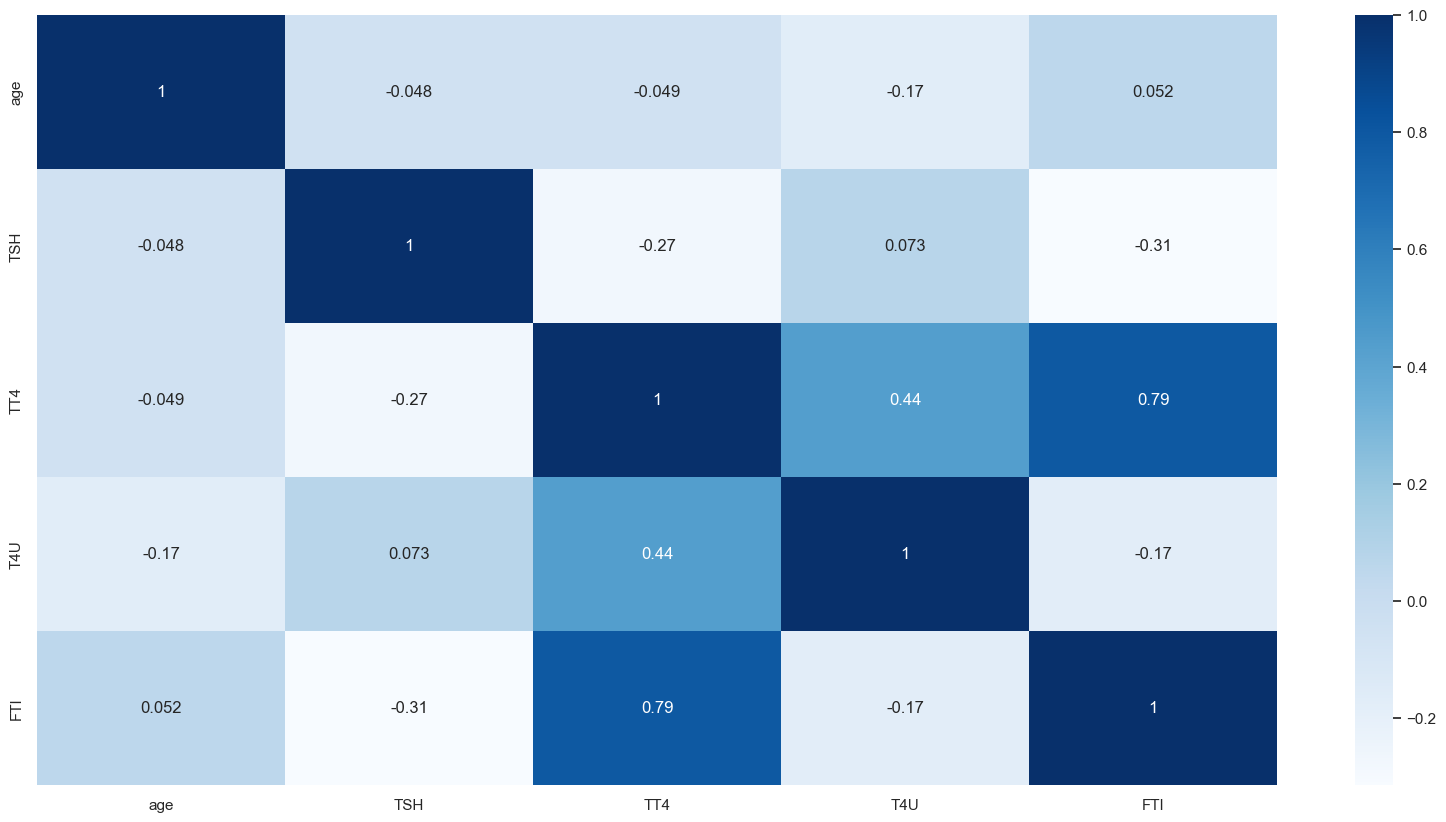

In [100]:
## Visualizing correlations of numeric features
print("Figure 1: Correlations of numeric features")
numeric = hypo_clean[['age', 'TSH', 'TT4', 'T4U', 'FTI']]
cor = numeric.corr()
plt.figure(figsize=(20, 10))
sn.set(font_scale=1)
sn.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [101]:
print("Figure 2: Realization of class counts")
pd.DataFrame(hypo_clean['binaryClass'].value_counts())

Figure 2: Realization of class counts


,binaryClass
1,2845
0,258


In [102]:
## Splitting data
X = hypo_clean.drop(columns = "binaryClass")
y = hypo_clean['binaryClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,TT4,T4U,FTI
3412,72.0,F,t,f,f,t,f,f,f,f,f,f,f,f,f,f,1.7,113.0,0.85,132.0
1910,39.0,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,2.2,98.0,0.88,110.0
1774,72.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.3,111.0,1.06,105.0
2732,64.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,0.3,123.0,1.23,100.0
2599,30.0,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,2.6,82.0,1.03,79.0


In [103]:
## Preprocessing data
onehot = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych',
           'hypopituitary']
numeric = ['age', 'TSH', 'TT4', 'T4U', 'FTI']

In [104]:
ct = make_column_transformer(
    (StandardScaler(), numeric), 
    (OneHotEncoder(handle_unknown = 'ignore'), onehot)
)

In [105]:
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)
transformed_X_test

array([[-0.37396382, -0.14772429, -0.21843872, ...,  1.        ,
         0.        ,  1.        ],
       [-0.85929449, -0.18825588, -0.88524438, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.25696606, -0.07873434, -1.05194579, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.90782756, -0.19946675, -0.13508801, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.27616047,  0.03337432, -0.4129237 , ...,  1.        ,
         0.        ,  1.        ],
       [-0.95636063, -0.1304768 ,  0.83733691, ...,  0.        ,
         1.        ,  1.        ]])

In [106]:
## Creating Kmeans classifier
kmeans = KMeans(n_clusters = 2)
kmeans.fit(transformed_X_train)
train_preds = kmeans.predict(transformed_X_train)

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Figure 3: Visualization of Clusters with TSH and TT4 concentration on the axes for training set


Text(0, 0.5, 'TT4 concentration')

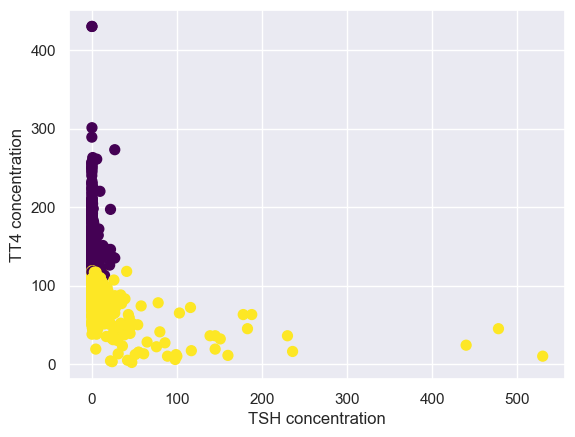

In [110]:
print("Figure 3: Visualization of Clusters with TSH and TT4 concentration on the axes for training set")
plt.scatter(X_train["TSH"], X_train["TT4"], c=train_preds, s=50, cmap='viridis')
plt.xlabel("TSH concentration")
plt.ylabel("TT4 concentration")


In [108]:
y_train.head()

3412    1
1910    1
1774    1
2732    1
2599    1
Name: binaryClass, dtype: category
Categories (2, int64): [0, 1]

In [109]:
accuracy_score(train_preds, y_train)

0.611878453038674

In [113]:
## Test set
test_preds = kmeans.predict(transformed_X_test)

Figure 4: Visualization of Clusters with TSH and TT4 concentration on the axes for test set


Text(0, 0.5, 'TT4 concentration')

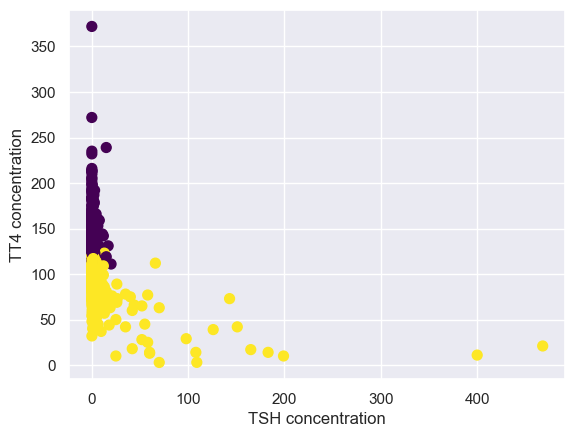

In [114]:
print("Figure 4: Visualization of Clusters with TSH and TT4 concentration on the axes for test set")
plt.scatter(X_test["TSH"], X_test["TT4"], c=test_preds, s=50, cmap='viridis')
plt.xlabel("TSH concentration")
plt.ylabel("TT4 concentration")

In [115]:
accuracy_score(test_preds, y_test)

0.6047261009667024